**Model:** VGG19 (Pretrained)

**Content Weight:** 1.5

**Style Weight:** 1e8

**Optimizer:** LBFGS

**Loss Functions:** MSE Loss (Content + Style)

**Epochs:** 400

Step 50/400 | Loss: 460589440696320.00
Step 100/400 | Loss: 87606578642944.00
Step 150/400 | Loss: 19531598659584.00
Step 200/400 | Loss: 9237806710784.00
Step 250/400 | Loss: 5083663171584.00
Step 300/400 | Loss: 3321338003456.00
Step 350/400 | Loss: 2403519430656.00
Step 400/400 | Loss: 1859274801152.00


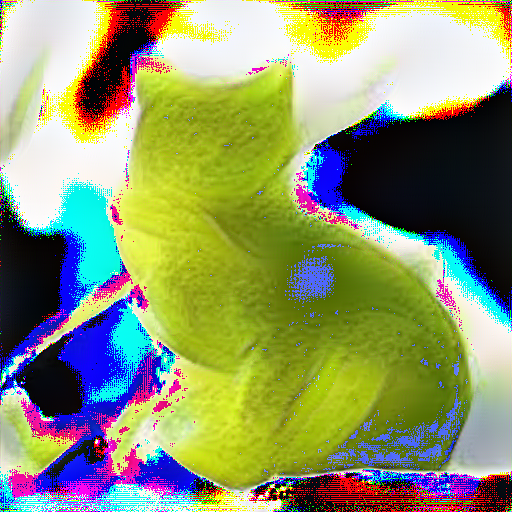

In [ ]:
!pip install torch torchvision pillow

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image

def load_image(path, size=512):
    image = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

content_path = "/content/cat.jpg"
style_path = "/content/ball.jpg"

content_img = load_image(content_path)
style_img = load_image(style_path)

device = torch.device("cpu")
content_img = content_img.to(device)
style_img = style_img.to(device)

cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

style_weight = 1e8
content_weight = 1.5

generated = content_img.clone().requires_grad_(True)

optimizer = optim.LBFGS([generated])

mse = nn.MSELoss()

layers = {"0": "conv1", "5": "conv2", "10": "conv3", "19": "conv4", "28": "conv5"}

def get_features(image):
    features = {}
    x = image
    for name, layer in cnn._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

content_features = get_features(content_img)
style_features = get_features(style_img)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

steps = 400
run = [0]

while run[0] < steps:
    def closure():
        optimizer.zero_grad()

        gen_features = get_features(generated)

        content_loss = mse(gen_features["conv4"], content_features["conv4"])

        style_loss = 0
        for layer in style_grams:
            gen_f = gen_features[layer]
            gen_g = gram_matrix(gen_f)
            style_loss += mse(gen_g, style_grams[layer])

        total_loss = content_weight * content_loss + style_weight * style_loss

        total_loss.backward(retain_graph=True)

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}/{steps} | Loss: {total_loss.item():.2f}")

        return total_loss

    optimizer.step(closure)

output = transforms.ToPILImage()(generated.squeeze(0).detach())
output.save("style_transfer_result.jpg")
output
